In [2]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline

from data_prep import load_and_preprocess_data
from ROC_gen import ROC_Generator
from conf_matrix import Matrix_Display
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

X_train, X_test, y_train, y_test, X, y = load_and_preprocess_data()



In [3]:
pipe = Pipeline([
        ('smotetomek', SMOTETomek(random_state=42)),
        ('clf', XGBClassifier(random_state=42))
        ])

search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0),
    }

opt = BayesSearchCV(pipe, search_space, cv=15, n_iter=20, scoring='roc_auc', random_state=42)




In [4]:
opt.fit(X_train, y_train)


,estimator,"Pipeline(step...=None, ...))])"
,search_spaces,"{'clf__colsample_bylevel': Real(low=0.5,...m='normalize'), 'clf__colsample_bynode': Real(low=0.5,...m='normalize'), 'clf__colsample_bytree': Real(low=0.5,...m='normalize'), 'clf__gamma': Real(low=0.0,...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,20
,scoring,'roc_auc'
,fit_params,None
,n_jobs,1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,15


In [5]:
opt.best_estimator_


,steps,"[('smotetomek', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,'auto'
,random_state,42
,smote,None
,tomek,None
,n_jobs,None
,objective,'binary:logistic'
,base_score,None


In [6]:
opt.best_score_
#best CV F1

np.float64(0.7866976845266319)

In [7]:
opt.score(X_test, y_test)


0.7471949509116409

In [8]:
opt.best_estimator_.steps

[('smotetomek', SMOTETomek(random_state=42)),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.9222454649222211,
                colsample_bynode=0.8793723800552331,
                colsample_bytree=0.9562772104169199, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, feature_weights=None,
                gamma=0.0, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.32752810774529634,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=4, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, ...))]

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

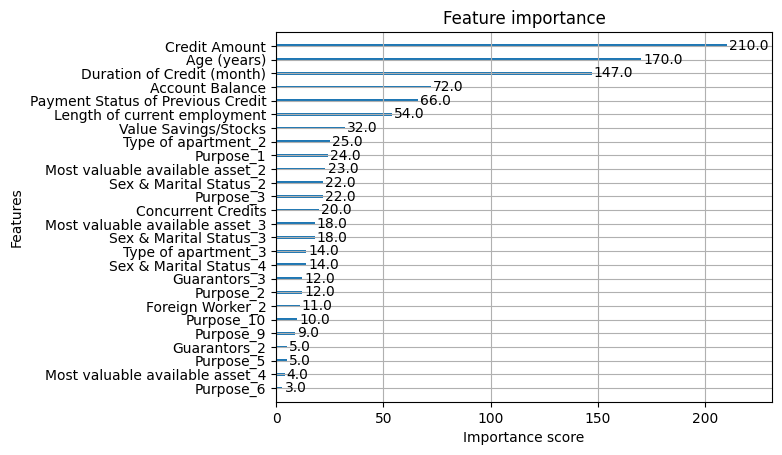

In [9]:
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)


In [11]:
y_pred = opt.predict(X_test)

In [13]:
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.60      0.57        62
           1       0.81      0.78      0.79       138

    accuracy                           0.72       200
   macro avg       0.68      0.69      0.68       200
weighted avg       0.73      0.72      0.72       200



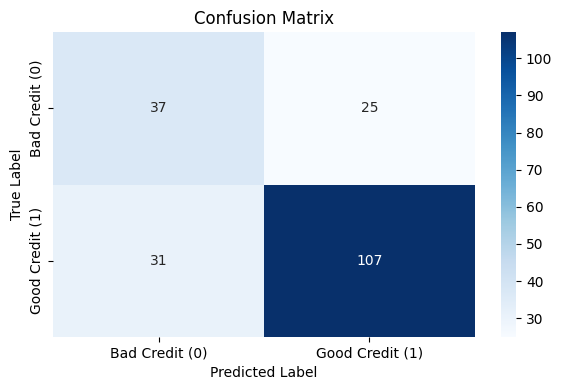

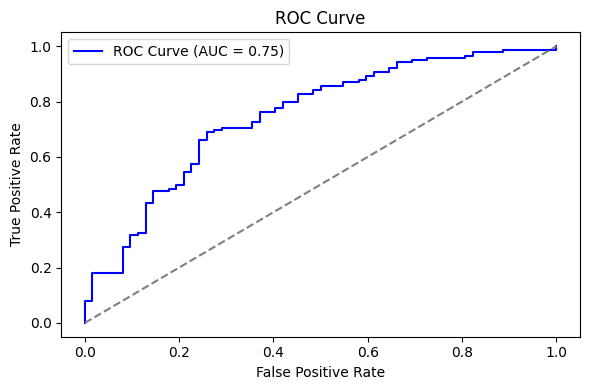

In [14]:
Matrix_Display(y_test, y_pred)
y_probs = opt.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
ROC_Generator(fpr,tpr,roc_auc)
